In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

plt.rc('font', family='Malgun Gothic') 

d

In [46]:
class fruits:

    def __init__(self,df):
        self.df = df
        self.df = self.df[1:].replace(0, np.NaN)
        self.df = self.df.interpolate().fillna(0)

        self.df.date = pd.to_datetime(self.df.date)
        self.df = pd.concat([self.df, pd.get_dummies(df['요일'])], axis=1)
        self.df = self.df.sort_values('date').reset_index(drop=True)
        self.feature = self.df.columns[2:]

        self.df['year'] = self.df['date'].dt.year
        self.df['month'] = self.df['date'].dt.month
        self.df['day'] = self.df['date'].dt.day

        def replace_zero_with_mean(df, column):
            for i in range(len(df)):
                if df[column][i] == 0:
                    if i == 0:
                        df.at[i, column] = (df[column][i+1] + df[column][i+2]) / 2
                    elif i == len(df) - 1:
                        df.at[i, column] = (df[column][i-1] + df[column][i-2]) / 2
                    else:
                        df.at[i, column] = (df[column][i-1] + df[column][i+1]) / 2

        for column in df.columns:
            if '_가격(원/kg)' in column:
                replace_zero_with_mean(df, column)

    def set_feature(self, name):
        self.name = name
        self.name1 = name+"_가격(원/kg)"
        self.name2 = name+"_거래량(kg)"

        self.feature = [ self.name2, 'year', 'month', 'day', '금요일', '목요일', '수요일', '월요일', '일요일', '토요일', '화요일', 'resid']


    def set_target(self, week):
        if week == 1:
            self.df['target'] = self.df[self.name1].shift(-7)
        elif week == 2:
            self.df['target'] = self.df[self.name1].shift(-14)
        elif week == 4:
            self.df['target'] = self.df[self.name1].shift(-28)

        stl = STL(self.df[['date', self.name1]].set_index('date'), period=12)
        stl = STL(self.df[['date', self.name1]].set_index('date'), period=12)
        res = stl.fit()
        self.df['resid'] = res.resid.values

        self.target = ['target']

    def set_model(self, time_step=7):
        self.df.dropna(inplace=True)
        self.data = self.df[self.feature + self.target]

        self.scaler = MinMaxScaler()
        self.scaled_data = self.scaler.fit_transform(self.data)

        def create_dataset(data, time_step):
            X, Y = [], []
            for i in range(len(data) - time_step - 1):
                X.append(data[i:(i + time_step), :-1])
                Y.append(data[i + time_step, -1])
            return np.array(X), np.array(Y)

        self.X, self.Y = create_dataset(self.scaled_data, time_step)

        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X, self.Y, test_size=0.25, random_state=42)

        self.model = Sequential()
        self.model.add(LSTM(100, return_sequences=True, input_shape=(self.X_train.shape[1], self.X_train.shape[2])))
        self.model.add(Dropout(0.1))
        self.model.add(LSTM(50, return_sequences=False))
        self.model.add(Dense(25))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(1))

        self.model.compile(optimizer='adam', loss='mean_squared_error')
        self.model.fit(self.X_train, self.Y_train, epochs=100, batch_size=32)

    def get_plot(self):
# Train
        self.train_predictions = self.model.predict(self.X_train)
        self.train_predictions = self.scaler.inverse_transform(np.concatenate((self.train_predictions, np.zeros((self.train_predictions.shape[0], len(self.feature)))), axis=1))[:, 0]
        self.Y_train_true = self.scaler.inverse_transform(np.concatenate((self.Y_train.reshape(-1, 1), np.zeros((self.Y_train.shape[0], len(self.feature)))), axis=1))[:, 0]

        self.train_r2 = r2_score(self.Y_train_true, self.train_predictions)
        print("Train R²: ", self.train_r2)


        # Test 
        self.test_predictions = self.model.predict(self.X_test)
        self.test_predictions = self.scaler.inverse_transform(np.concatenate((self.test_predictions, np.zeros((self.test_predictions.shape[0], len(self.feature)))), axis=1))[:, 0]
        self.Y_test_true = self.scaler.inverse_transform(np.concatenate((self.Y_test.reshape(-1, 1), np.zeros((self.Y_test.shape[0], len(self.feature)))), axis=1))[:, 0]

        self.mse = mean_squared_error(self.Y_test_true, self.test_predictions)
        self.mae = mean_absolute_error(self.Y_test_true, self.test_predictions)
        self.rmse = np.sqrt(self.mse)
        self.r2 = r2_score(self.Y_test_true, self.test_predictions)

        print("Test MSE: ", self.mse)
        print("Test MAE: ", self.mae)
        print("Test RMSE: ", self.rmse)
        print("Test R²: ", self.r2)

        plt.figure(figsize=(12, 6), dpi=300)
        plt.plot(range(len(self.Y_test_true)),self.Y_test_true, alpha=0.9, label='Real')
        plt.plot(range(len(self.test_predictions)), self.test_predictions, label='Predict')
        plt.title(self.name + ' 가격 예측 결과'+   '   MAE : ' + str(self.mae)[:7])
        plt.ylabel(self.name + ' 가격')
        plt.legend()
        plt.show()

    def get_price(self):
        self.last_row = self.df[self.feature].iloc[-1].values.reshape(1, 1, len(self.feature))
        self.last_row = self.last_row.astype(np.float32)
        self.price = self.model.predict(self.last_row)
        
        self.predicted_price = np.zeros((self.price.shape[0], len(self.feature) + 1)) 
        self.predicted_price[:, 0] = self.price.flatten() 
        
        self.price = self.scaler.inverse_transform(self.predicted_price) 
        return self.price[0][0]


In [47]:
df = pd.read_csv("C:\\Users\\user\\jupyter\\traintest.csv")

In [48]:
my_fruit = fruits(df)

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)


In [49]:
my_fruit.set_feature('사과')

In [50]:
my_fruit.set_target(1)

In [51]:
my_fruit.set_model()

Epoch 1/100


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0446
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0299
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0294
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0244
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0299
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0260
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0252
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0227
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0198
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0186
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0157
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0130
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159
Epoch 16/100
28/

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Train R²:  0.8850951394262109
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test MSE:  69555354334.80962
Test MAE:  194115.50158446425
Test RMSE:  263733.491113301
Test R²:  0.8705790317614631


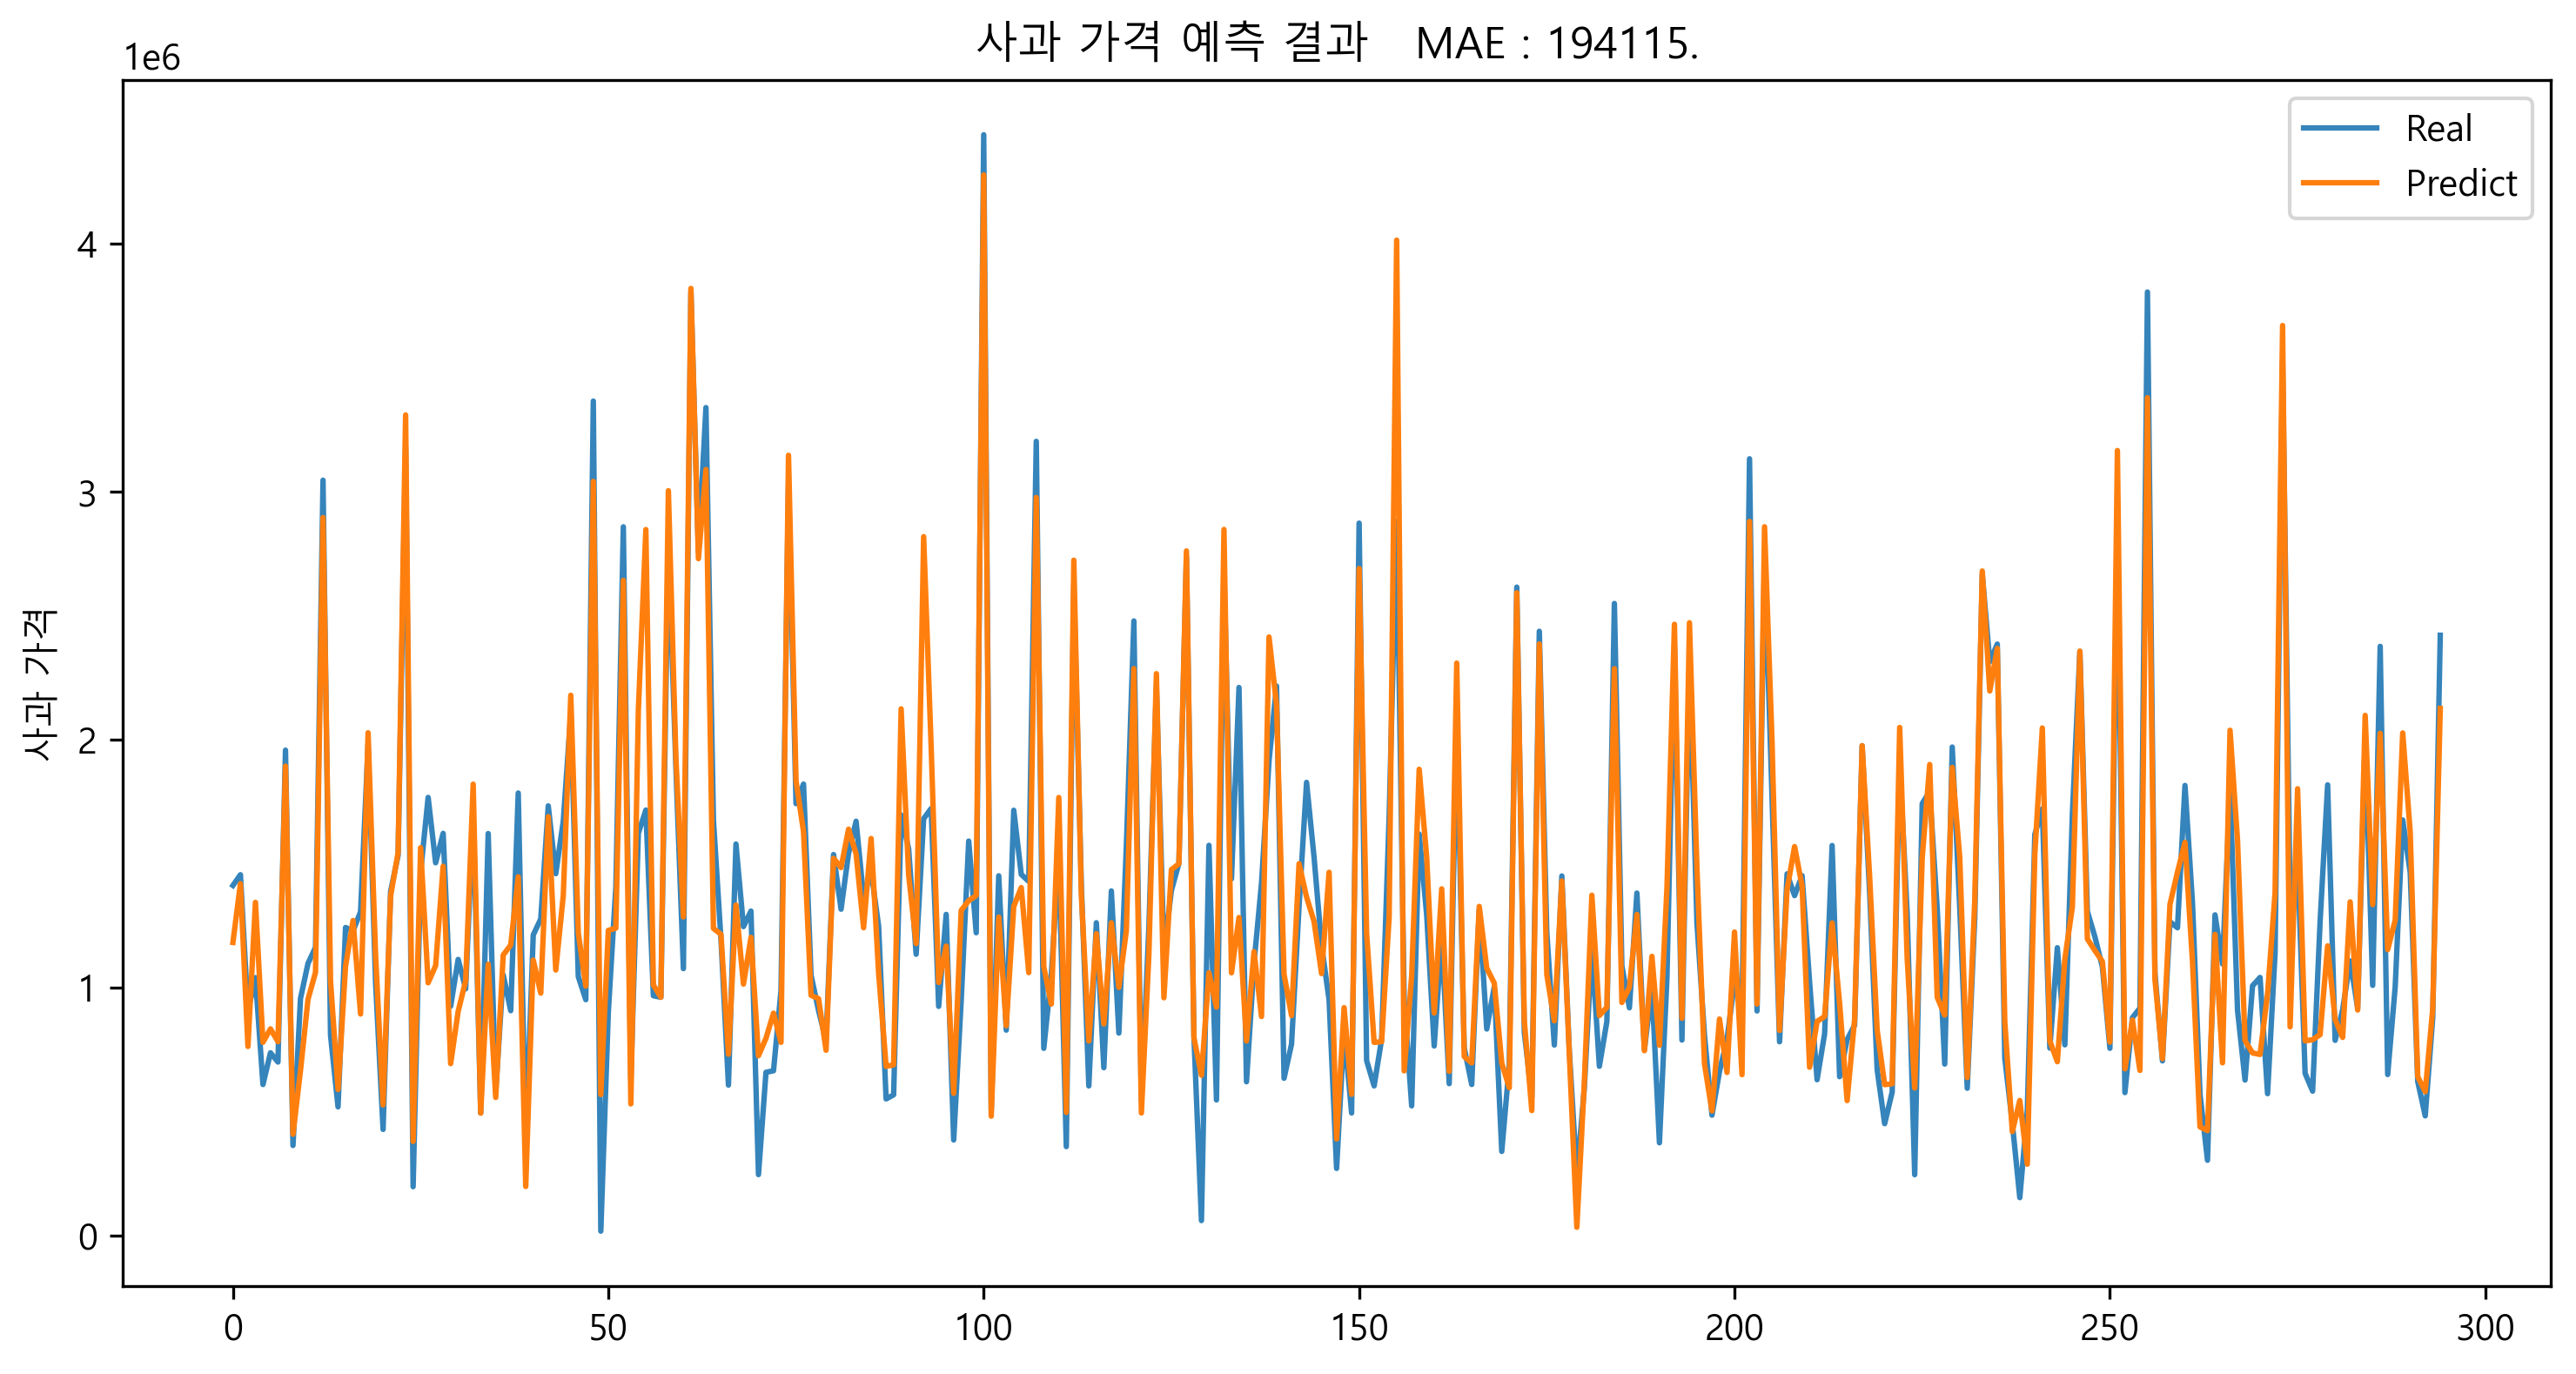

In [8]:
my_fruit.get_plot()

In [52]:
weeks=[1,2,4]
features = ['포도', '망고', '체리', '레몬', '블루베리', '수박' ,'딸기', '메론', '사과', '참외', '감귤', '바나나', '복숭아', '참다래(키위)', '자두', '파인애플']

week1=[]
week2=[]
week4=[]

for week in weeks :
    print(week)
    for feature in features:
        my_fruit = fruits(df)
        my_fruit.set_feature(feature)
        my_fruit.set_target(week)
        my_fruit.set_model()
        if week == 1:
            week1.append(my_fruit.get_price())
        if week == 2:
            week2.append(my_fruit.get_price())
        if week == 4:
            week4.append(my_fruit.get_price())
        print(f'{feature} - {week}주차 예측 완료')


1
Epoch 1/100


C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0643
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0333
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0333
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0311
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0346
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0289
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0321
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0285
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0296
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0317
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0310
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0304
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0286
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0298
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0319
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0277
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0682
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0410
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0366
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0391
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0412
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0444
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0379
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0375
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0385
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0381
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0403
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0392
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0414
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0381
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0427
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0553
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0175
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0160
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0155
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0157
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0126
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0116
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0118
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0117
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0359
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0120
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0211
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0134
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0129
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0436
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0292
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0252
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0252
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0259
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0221
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0196
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0173
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0156
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0151
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0182
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0125
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0132
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0517
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0167
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0142
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0129
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0151
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0131
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0136
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1056
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0237
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0152
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0127
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0143
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1120
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0260
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0252
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0252
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0248
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0249
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0233
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0245
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0242
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0245
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0232
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0247
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0242
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0232
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0247
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0181
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0125
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0131
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0113
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0517
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0208
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0210
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0219
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0186
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0164
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0178
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0159
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0146
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0170
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0156
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0173
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0165
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0150
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0149
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0122
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0666
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0136
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0116
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0112
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0517
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0333
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0319
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0313
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0299
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0299
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0295
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0288
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0297
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0258
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0275
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0262
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0273
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0283
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0294
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0352
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0123
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0101
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0084
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0903
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0409
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0432
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0423
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0403
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0436
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0397
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0412
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0412
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0413
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0381
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0424
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0423
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0391
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0417
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0488
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0179
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0151
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0140
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0175
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0132
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0156
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0123
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0132
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0136
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0137
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0172
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0190
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0239
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0083
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0084
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059
Epoch 16

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0274
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0168
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0132
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0122
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0123
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0087
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0093
Epoch 16

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0407
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0256
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0268
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0241
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0245
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0185
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0193 
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0169
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0151
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0140
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0152
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0131
Epoch

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0354
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0150
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0145
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0145
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0134
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0135
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0101
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0116
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0116
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103
Epoch 16

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0992
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0263
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0225
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0191
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0208
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0188
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0179
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0142
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0135
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0129
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0137
Epoch 16/1

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0994
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0261
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0245
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0226
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0233
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0239 
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0233
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0211 
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0218
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0224
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0217
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0213
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0220
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0237
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0214
Epoch 16/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0233
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0120
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0134
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0088
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0094
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0105
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089
Epoch 16/100

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0614
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0223
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0202
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0197
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0188
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0195
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0156
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0145
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0145
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127
Epoch 16/100

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0229
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0128
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0133
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0135
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0122
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0116
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0108
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0089
Epoch 16/100

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0421
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0136
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0131
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0122
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0109
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0126
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0106
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107
Epoch 16/100
2

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0832
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0322
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0286
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0274
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0274
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0269
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0267
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0282
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0266
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0238
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0258
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0238
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0237
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0248
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0253
Epoch 1

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0225
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0142
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0128
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0123
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0122
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0100
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0121
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0100
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0092
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0094
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073
Epoch 1

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0820
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0414
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0369 
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0428
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0406
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0411
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0425
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0420
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0441
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0430
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0416
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0432
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0402
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0395
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0411
Ep

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0663
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0150
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0142
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0140
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0134
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0135
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0144
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0161
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0135
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0142
Epoc

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0141
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068
Epoch 16/100

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0291
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056
Epoch 16/10

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0165
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0087
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0074
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064
Epoch 16/100

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0247
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0156
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0117
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0079
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0091
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0098
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0348
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0241
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0231
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0253
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0224
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0216
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0195
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0179
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0176
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0151
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0149
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0202
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0137
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0150
Ep

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0308
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0167
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0138
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0109
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0108
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0121
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0124
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0802
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0254
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0249
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0216
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0202
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0226
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0180
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0146
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0169 
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0149
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127
Epoch 16/100


C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0777
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0226
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0219
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0201
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0193
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0200
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0218
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0195
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0217
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0205
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0219
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195
Epoch 16/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0149
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0120
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0108
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0129
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0116
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0143
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0121
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0100
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0102
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0124
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0097
Epoch 16/100

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0614
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0206
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0196
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0218
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0185
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0197
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0182
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0184
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0158
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0141
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0143
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0133
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0147
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0142
Epoch 16/100

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0178
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0147
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0137
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0154
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0114
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0126
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0108
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0126
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119
Epoch 16/10

C:\Users\user\AppData\Local\Temp\ipykernel_28260\2130275798.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0635
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0167
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0150
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0122
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0138
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0117
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0114
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0117
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0107
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0105
Epo

In [20]:
weeks=[1,2,4]
features = ['포도', '망고', '체리', '레몬', '블루베리', '수박' ,'딸기', '메론', '사과', '참외', '감귤', '바나나', '복숭아', '참다래(키위)', '자두', '파인애플']

week1=[]
week2=[]
week4=[]

for week in weeks :
    print(week)
    for feature in features:
        my_fruit = fruits(df)
        my_fruit.set_feature(feature)
        my_fruit.set_target(week)
        my_fruit.set_model()
        if week == 1:
            week1.append(my_fruit.get_price())
        if week == 2:
            week2.append(my_fruit.get_price())
        if week == 4:
            week4.append(my_fruit.get_price())
        print(feature)


1
Epoch 1/100


C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0776
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0314
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0334
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0295
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0335
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0323
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0320
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0344
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0328
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0299
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0339
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0298
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0275
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0299
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0302
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0292
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0815
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0418
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0436
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0388
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0398
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0403
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0394
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0416
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0425
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0375
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0378
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0366
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0396
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0364
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0406
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0550
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0180
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0151
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0133
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0137
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0137
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0118
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0122
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0116
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0172
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0467
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0072
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0063
Epoch 16/100


C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0182
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0311
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0136
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0140
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0110
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0097
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0094
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085
Epoch 16/100


C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0613
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0290
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0269
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0266
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0264
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0245
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0215
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0209
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0184
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0181
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0185
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0165
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0141
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0140
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0346
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0155
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0132
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0820
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0219
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0162
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0182
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0181
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0167
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0135
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0112
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1143
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0276
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0250
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0258
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0229
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0256
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0220
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0257
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0233
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0225
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0232
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0223
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0228
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0244
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0223
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0143
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0130
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0101
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0526
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0198
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0192
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0190
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0194
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0190
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0171
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0164
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0150
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0161
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0136
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0164
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0157
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0157
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0239
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0137
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0140
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0111
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0113
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119
Epoch 16/100


C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0789
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0135
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0142
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0118
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0106
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0542
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0324
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0292
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0311
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0293
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0290
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0278
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0283
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0283
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0269
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0278
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0264
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0282
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0246
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0239
Epoch 16/100

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0247
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0111
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0098
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0118
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0087
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083
Epoch 16/10

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0678
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0447
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0397
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0417
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0389
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0431
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0376
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0372
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0422
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0417
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0425
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0401 
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0407
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0393
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0368
Epoch 16/10

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0557
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0161
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0155
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0146
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0123
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0134
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0140
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0137
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0148
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0137
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0140
Epoch 16/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0139
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0073
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049
Epoch 16/100
28

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0185
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0099
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0070
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0077
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075
Epoch 16/1

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0168
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0329
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0123
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0111
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062
Epoch 16/1

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0643
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0285
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0280
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0294
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0246
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0216
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0219
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0188
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0180
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0148
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0143
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0135
Epoch 1

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0403
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0138
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0128
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0133
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0124
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0097
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093
Epoch

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0895
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0313
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0221
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0205
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0212
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0187
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0147
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0178
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0142
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0123
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0129
Epo

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0875
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0237
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0219
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0252
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0251
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0261
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0247
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0233
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0258
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0233
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0228
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0220
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0228
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0228
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0223
E

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0132
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0106
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0126
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0107
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0106
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0106
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0088
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083
Epoch 16/10

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0425
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0219
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0198
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0199
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0183
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0171
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0136
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0146
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0162
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0149
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0142
Epoch 16/10

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0191
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0137
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098 
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0111
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104
E

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0455
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0148
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0133
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0122
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102
Epoch 16/100
28

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0627
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0308
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0253
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0267
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0250
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0253
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0229
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0267
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0257
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0247
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0239
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0243
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0240
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0264
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0224
Epoch 16/10

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0320
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0168
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0131
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0122
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0128
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0117
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0092
Epoch 16/100

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0791
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0440
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0422
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0461
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0424
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0419
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0412
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0442
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0437
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0421
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0396
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0368
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0399
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0398
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0412
Epoch 16/100
2

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0450
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0165
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0148
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0149
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0148
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0144
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0141
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0145
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0131
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0141
Epoch 

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0108
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0048
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0046
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058
Epoch 16/100


C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0289
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0090
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0089
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0201
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074
Epoch 16/100
28

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0161
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0138
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0489
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0250
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0251
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0247
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0222
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0220
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0194
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0175
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0158
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0164
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0149
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0134
Epoch 16/100
28

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0256
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0141
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0141
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0136
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0149
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1393
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0304
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0244
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0227
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0215
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0224
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0213
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0182
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0186
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0150
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0140
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0173
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0177
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1474
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0247
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0263
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0216
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0206
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0220
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0232
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0193
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0210 
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0204
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0226
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0196
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0197
Epoch 16/100
28

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0197
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0112
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0127
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0106
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095
Epoch 16/100
28

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0454
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0194
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0195
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0203
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0177
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0187
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0147
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0145
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0140
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0142
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0160
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0226
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0146
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0141
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0141
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0131
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0133
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0126
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0121
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120
Epoch 16/100
28/

C:\Users\user\AppData\Local\Temp\ipykernel_28260\840367280.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.df = self.df.interpolate().fillna(0)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0474
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0140
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0146
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0140
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0126
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0116
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0134
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0117
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0129
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115
Epoch 16/100
28/

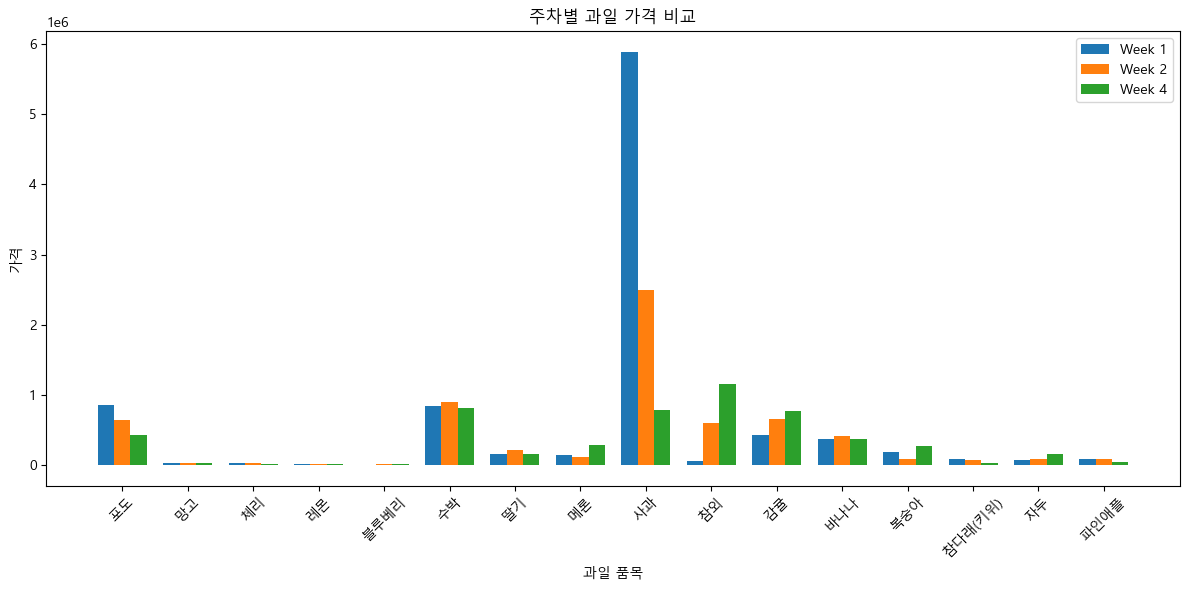

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# 주차별 과일 가격 데이터
fruits = features
week1_prices = week1  # 주 1 가격
week2_prices = week2  # 주 2 가격
week4_prices = week4  # 주 4 가격

# 막대 그래프 설정
x = np.arange(len(fruits))  # 과일 품목의 인덱스
width = 0.25  # 막대 너비

# 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, week1_prices, width, label='Week 1')
bars2 = ax.bar(x, week2_prices, width, label='Week 2')
bars3 = ax.bar(x + width, week4_prices, width, label='Week 4')

# 레이블 설정
ax.set_xlabel('과일 품목')
ax.set_ylabel('가격')
ax.set_title('주차별 과일 가격 비교')
ax.set_xticks(x)
ax.set_xticklabels(fruits, rotation=45)
ax.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


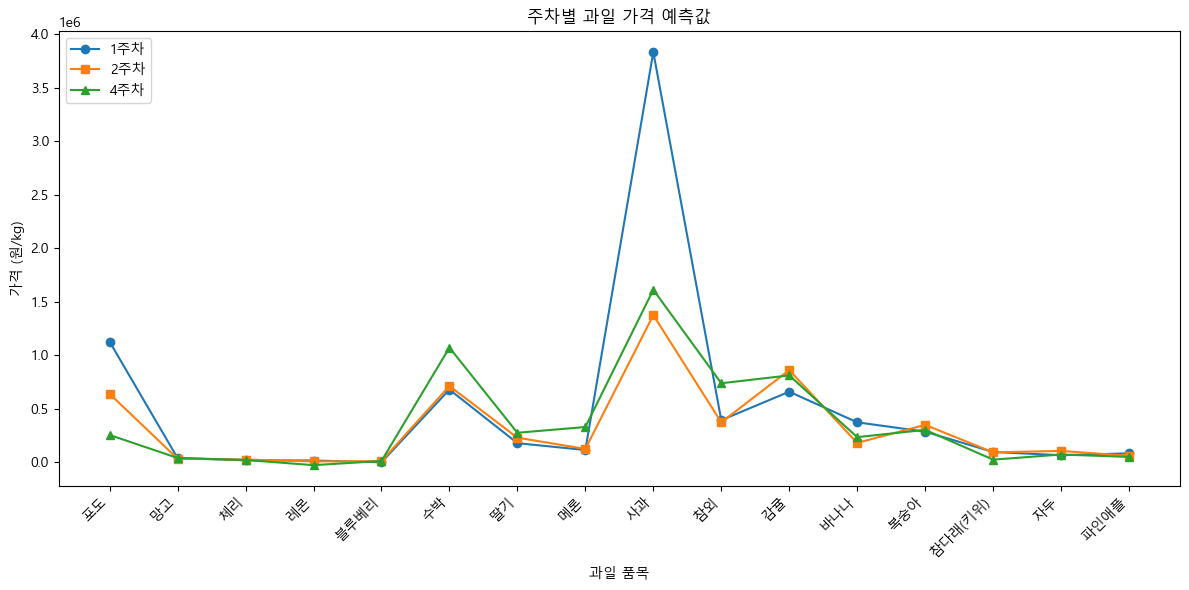

In [55]:
import matplotlib.pyplot as plt

# 시각화: 주차별 예측값 비교
plt.figure(figsize=(12, 6))

# 각 주차별 예측값을 다른 색상으로 표시
plt.plot(features, week1, label="1주차", marker='o')
plt.plot(features, week2, label="2주차", marker='s')
plt.plot(features, week4, label="4주차", marker='^')

plt.xlabel('과일 품목')
plt.ylabel('가격 (원/kg)')
plt.title('주차별 과일 가격 예측값')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_28260\2987551396.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Paired', len(predictions_df))  # 'tab20' 컬러 맵을 사용하여 품목 수에 맞게 색상 자동 지정


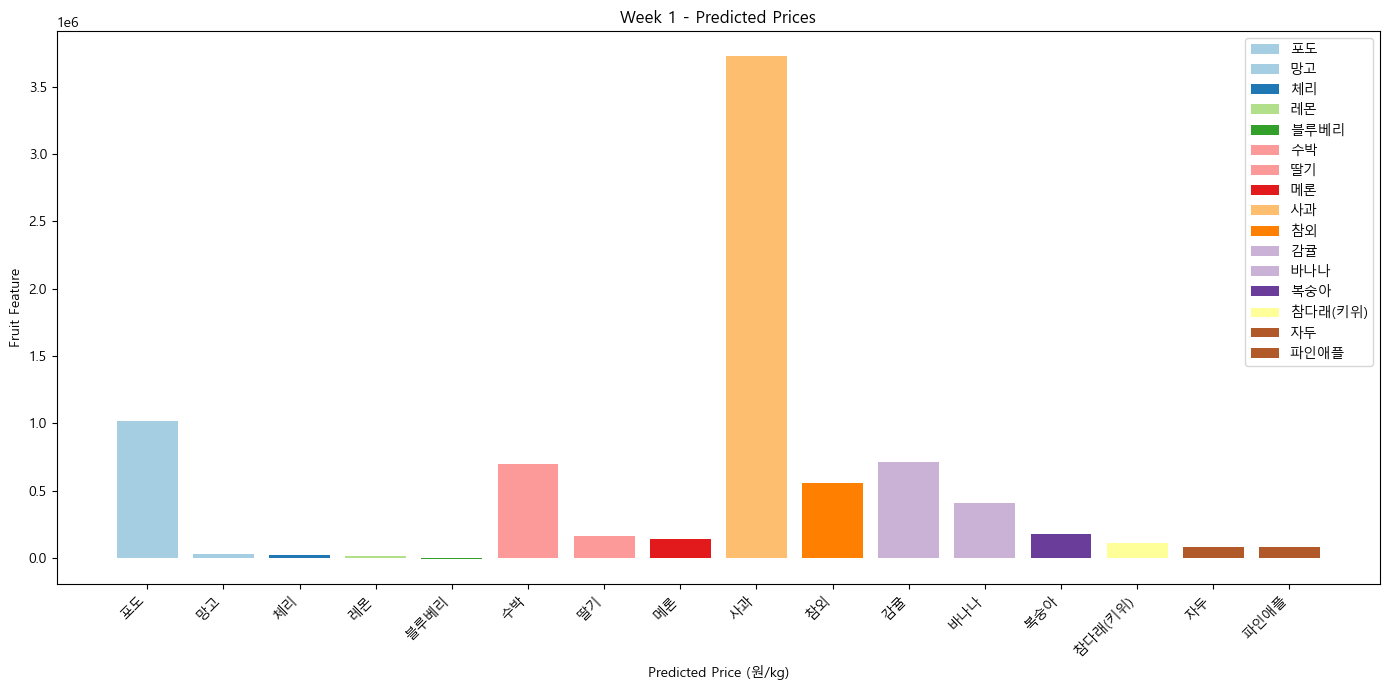

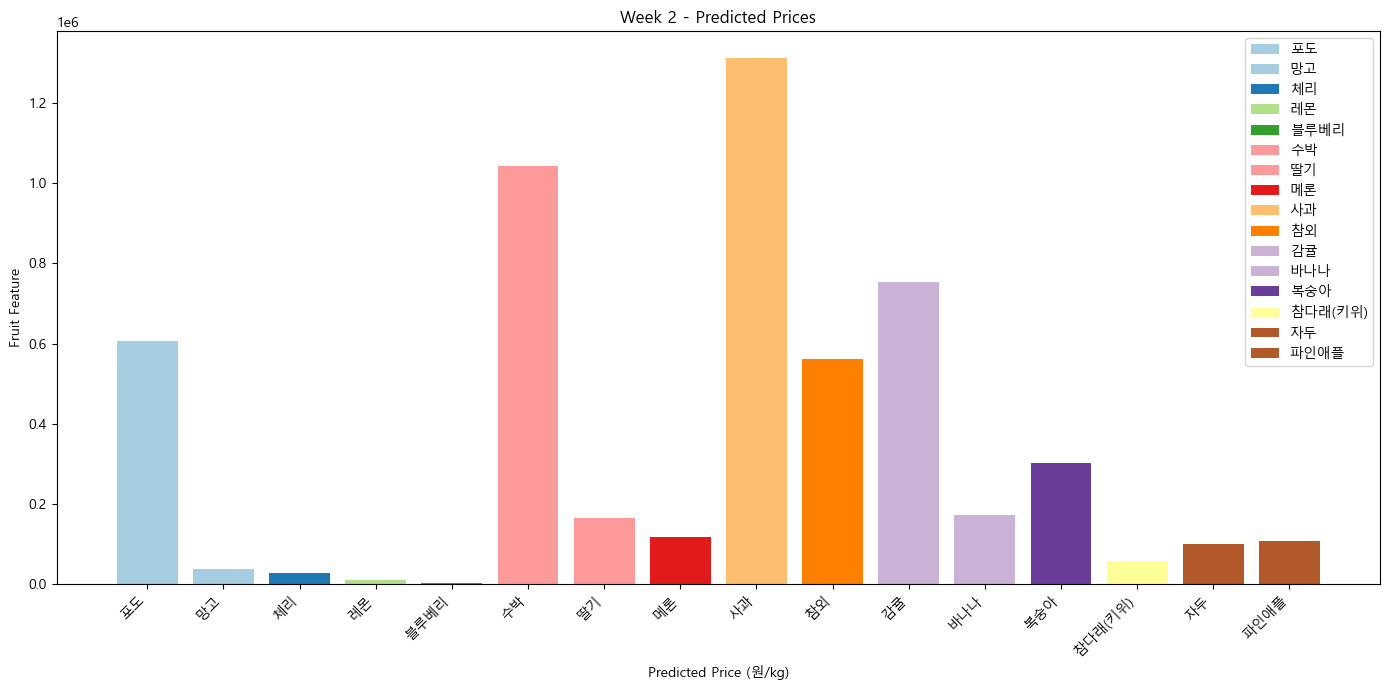

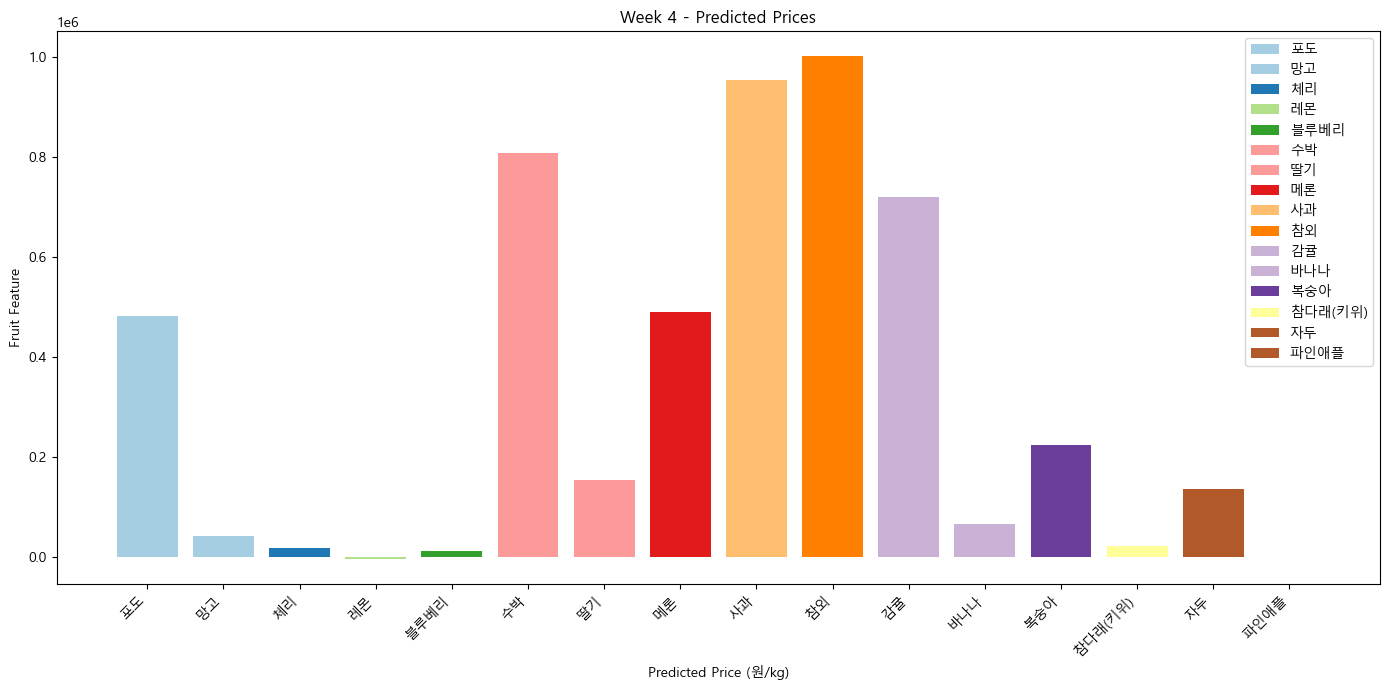

In [76]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(week_predictions, week_num):
    predictions_df = pd.DataFrame(week_predictions.items(), columns=["Feature", "Predicted Price"])
    
    colors = plt.cm.get_cmap('Paired', len(predictions_df))  # 'tab20' 컬러 맵을 사용하여 품목 수에 맞게 색상 자동 지정
    
    # 그래프 생성
    plt.figure(figsize=(14, 7))
    
    # 수직 바 차트로 가격 예측값 시각화 (색상 다르게 지정)
    bars = plt.bar(predictions_df["Feature"], predictions_df["Predicted Price"], color=colors(np.arange(len(predictions_df))))
    
    # 그래프 제목, 라벨 등 설정
    plt.title(f"Week {week_num} - Predicted Prices")
    plt.ylabel('Fruit Feature')
    plt.xlabel('Predicted Price (원/kg)')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.legend(bars, predictions_df["Feature"], loc="best")
    plt.show()

# 주차별 품목별 예측값 시각화
plot_predictions(week1_predictions, 1)
plot_predictions(week2_predictions, 2)
plot_predictions(week4_predictions, 4)
